In [118]:
import json
class Metric:
    def __init__(self, results):
        self.results = results

    def tag_potentially_competency_groups(self, include_all_domains=False):
        """ Tag potentially competency groups.
        Technically, they should not be specific to the domain.
        Instead, we should include all domains, making sure that tags for each domain align with the tags for other domains. 
        In other words, Examples in group 1 for one domain are semantically identical to examples in group 1 for another domain.
        """
        valid_tags_dict = {}
        valid_tags_across_domains = []
        for domain_name in self.results:
            valid_tags_for_each_domain = []
            for result in self.results[domain_name]:
                if result['judgement'] == 'Correct':
                    valid_tags_for_each_domain.append(result['query_tag'])
                    valid_tags_across_domains.append(result['query_tag'])

            valid_tags_dict[domain_name] = set(valid_tags_for_each_domain)
        if include_all_domains:
            valid_tags_dict["include_all_domains"] = set(valid_tags_across_domains)
        return valid_tags_dict
    
    def tag_non_robust_groups(self):
        """ Tag non-robust groups where there exists at least one example that is not correct.
        This is specific to the domain.
        """
        valid_tags_dict = {}
        for entity_with_spec in self.results:
            valid_tags = []
            for result in self.results[entity_with_spec]:
                if result['judgement'] != 'Correct':
                    valid_tags.append(result['query_tag'])

            valid_tags_dict[entity_with_spec] = set(valid_tags)
        return valid_tags_dict
    
    def get_all_tags(self, include_all_domains=False):
        tags_dict = {}
        all_tags_across_domains = []
        for entity_with_spec in self.results:
            tags = []
            for result in self.results[entity_with_spec]:
                tags.append(result['query_tag'])
                all_tags_across_domains.append(result['query_tag'])

            tags_dict[entity_with_spec] = set(tags)
        if include_all_domains:
            tags_dict["include_all_domains"] = set(all_tags_across_domains)
        return tags_dict
    
    def get_best_case_accuracy(self):
        results = self.results
        best_case_accuracy = {}
        competency_group_tags = self.tag_potentially_competency_groups()
        all_group_tags = self.get_all_tags()
        for entity_with_spec in results:
            try:
                best_case_accuracy[entity_with_spec] = len(competency_group_tags[entity_with_spec])/len(all_group_tags[entity_with_spec])
            except:
                Exception()
    
        return best_case_accuracy
    
    def get_non_robust_rates(self, to_robust_rates=False, return_group_sizes=False):
        results = self.results
        get_non_robust_rates = {}
        non_robust_groups = self.tag_non_robust_groups()
        all_group_tags = self.get_all_tags()
        # group sizes
        group_sizes = {}
        robust_group_sizes = {}
        for entity_with_spec in results:
            try:

                get_non_robust_rates[entity_with_spec] = len(non_robust_groups[entity_with_spec])/len(all_group_tags[entity_with_spec])
                if to_robust_rates:
                    get_non_robust_rates[entity_with_spec] = 1 - get_non_robust_rates[entity_with_spec]
                
                group_sizes[entity_with_spec] = len(all_group_tags[entity_with_spec])
                robust_group_sizes[entity_with_spec] = len(all_group_tags[entity_with_spec]) - len(non_robust_groups[entity_with_spec])
            except:
                Exception()
        if return_group_sizes:
            return get_non_robust_rates, {"All groups": group_sizes,  "Robust groups": robust_group_sizes}
        return get_non_robust_rates
    
    def get_accuracy(self, average_for_each_domain=False, average_all=False):
        """ Calculate accuracy
        """
        if average_all:
            assert not average_for_each_domain
        results = self.results
        if average_for_each_domain:
            # calculate accuracy
            accuracy = {}
            for domain_name in results:
                correct = 0
                for result in results[domain_name]:
                    if result['judgement'] == 'Correct':
                        correct += 1
                try:
                    accuracy[domain_name] = correct/len(results[domain_name])
                except:
                    Exception()
        elif average_all:
            correct = 0
            total = 0
            for domain_name in results:
                for result in results[domain_name]:
                    if result['judgement'] == 'Correct':
                        correct += 1
                    total += 1
            accuracy = correct/total
        else:
            raise Exception("Please Provide Aggregation method")
        
        return accuracy

    def get_robustness(self, average_for_each_domain=False, average_all=False, include_all_domains_for_tagging=True):
        """ Calculate robustness
        """
        results = self.results
        competency_group_tags = self.tag_potentially_competency_groups(include_all_domains=include_all_domains_for_tagging)
        if average_for_each_domain:
            
            robustness = {}
            for domain_name in results:
                correct = 0
                total = 0
                for result in results[domain_name]:
                    if include_all_domains_for_tagging:
                        potentially_competency_group_tags = competency_group_tags["include_all_domains"]
                    else:
                        potentially_competency_group_tags = competency_group_tags[domain_name]
                    if result['query_tag'] in potentially_competency_group_tags:
                        if result['judgement'] == 'Correct':
                            correct += 1
                        total += 1
                try:
                    robustness[domain_name] = correct/total
                except:
                    Exception()
        elif average_all:
            correct = 0
            total = 0
            for domain_name in results:
                for result in results[domain_name]:
                    if result['query_tag'] in competency_group_tags[domain_name]:
                        if result['judgement'] == 'Correct':
                            correct += 1
                    total += 1
            robustness = correct/total
        else:
            raise Exception("Please Provide Aggregation method")
        
        return robustness
    
    def get_num_correct_for_each_group(self):
        """  Returns the number of total, correct answers for each query logic group
        """
        
        ent_to_tagnum_dict = {ent: None for ent in self.results}
        
        ent_to_tags_dict = self.get_all_tags()
        
        for ent in ent_to_tags_dict:
            tag_to_nums_dict = {tag: None for tag in ent_to_tags_dict[ent]}
            
            for tag in ent_to_tags_dict[ent]:
                # in-group accuracy
                correct = 0
                total = 0
                for result in self.results[ent]:
                    if result['query_tag'] == tag:
                        if result['judgement'] == 'Correct':
                            correct += 1
                        total += 1
                tag_to_nums_dict[tag] = (correct, total)
        
            ent_to_tagnum_dict[ent] = tag_to_nums_dict
        return ent_to_tagnum_dict
    
    def print_accuracy_and_robustness(self):
        accuracy, robustness = self.get_accuracy_and_robustness(average_for_each_domain=True)
        print("Accuracy")
        for entity_with_spec in accuracy:
            print(f"{entity_with_spec}: {accuracy[entity_with_spec]}")
        print("Robustness")
        for entity_with_spec in robustness:
            print(f"{entity_with_spec}: {robustness[entity_with_spec]}")


class ContrastRobustness(Metric):
    def __init__(self, results, results_contrast, name="Orig", name_contrast="Contrast"):
        super().__init__(results)
        self.results_contrast = results_contrast

    def find_examples_for_tag(self, tag, query_answer_pairs):
        examples = []
        for qa in query_answer_pairs:
            if qa['query_tag'] == tag:
                examples.append(qa)
        return examples

    def get_contrast_robustness(self):
        """Compare the accuracy of a group in `results` with the accuracy of the corresponding group in `results_contrast`. Assign 1 if the accuracy of the group in `results` is greater than the accuracy of the group in `results_contrast` and 0 otherwise."""
        equal_robust = []
        all_tags = self.get_all_tags()
        num_robust_groups_in_results = {entity_with_spec: 0 for entity_with_spec in self.results}
        num_robust_groups_in_contrast_results = {entity_with_spec: 0 for entity_with_spec in self.results}
        for entity_with_spec in self.results:
            for tag in all_tags[entity_with_spec]:
                
                examples = self.find_examples_for_tag(tag, self.results[entity_with_spec])
                examples_contrast = self.find_examples_for_tag(tag, self.results_contrast[entity_with_spec])
                if len(examples) > 0 and len(examples_contrast) > 0:
                    accuracy = len([example for example in examples if example['judgement'] == 'Correct'])/len(examples)
                    accuracy_contrast = len([example for example in examples_contrast if example['judgement'] == 'Correct'])/len(examples_contrast)
                    if accuracy > accuracy_contrast:
                        num_robust_groups_in_results[entity_with_spec] += 1
                    elif accuracy < accuracy_contrast:
                        num_robust_groups_in_contrast_results[entity_with_spec] += 1
                    else: 
                        equal_robust.append(tag)
                else:
                    if len(examples) == 0:
                        print("No examples for tag: ")
                    if len(examples_contrast) == 0:
                        print(f"No examples for the query {tag} for {entity_with_spec} in contrast: ")
                        # print(examples)
                        # print(self.results_contrast[entity_with_spec])

        print("Number of groups: ", sum([ len(all_tags[entity_with_spec]) for entity_with_spec in self.results]))
        print("Number of Equal robustness: ", len(equal_robust))
        return num_robust_groups_in_results, num_robust_groups_in_contrast_results

In [119]:
from typing import Union, List, Dict
def print_cluster(group_details: Union[List, Dict], print_details=False):
    if type(group_details) == dict:
        tags = list(group_details.keys())
        group_details = list(group_details.values())
    else:
        tags = list(range(len(group_details)))
        
    if print_details:
        print(f"Index for Query Logic: (Correct, Total) in each group:")
        for i, (correct, total) in zip(tags, group_details):
            if correct==0:
                group_type = " => gap group" 
            elif correct==total:
                group_type = '' #" => Completely Competent Group"
            else:
                group_type = "=> Potentially Competent Group"
            print(f"\tGroup {i}: ({correct}, {total}){group_type}")

    num_gap_groups, num_gap_examples = len([total for correct, total in group_details if correct == 0]), sum([total for correct, total in group_details if correct == 0])
    print(f"Gap groups: {num_gap_groups} Groups with {num_gap_examples} Examples")
    num_complete_competent_groups, num_complete_competent_examples = len([1 for correct, total in group_details if total==correct and correct!=0]), sum([total for correct, total in group_details if total==correct and correct!=0]) 
    print(f"Competent groups: {num_complete_competent_groups} Groups with {num_complete_competent_examples} Examples")
    num_potentially_competent_groups, num_potentially_competent_examples = len([1 for correct, total in group_details if correct!=0 and correct!=total]), sum([total for correct, total in group_details if correct!=0 and correct!=total])
    print(f"Potentially competent groups: {num_potentially_competent_groups} Groups with {num_potentially_competent_examples} Examples")
    print(f"Total number of groups: {len(group_details)} groups with {sum([total for correct, total in group_details])} Examples")
    

def compare_robustness_accuracy(stratified=True, unbalanced=True):

    if stratified:
        print("\n")
        print("~~~~~Stratified Groups~~~~~")
        print("Non-robust cluster (long queries): (12 examples in gap groups, 12 in non-gap groups)")
        print_cluster([
            (1, 3),  # Group 0
            (2, 3),  # Group 1
            (3, 3),  # Group 2
            (2, 3),  # Group 3
            (0, 3),  # Group 4 (gap group)
            (0, 3),  # Group 5 (gap group)
            (0, 3),  # Group 6 (gap group)
            (0, 3)   # Group 7 (gap group)
        ])
        print("\tAccuracy:", round(8/24, 2), '(8 / 24)')
        print("\tRobustness:", round(8/12, 2), '(8 / 12)')

        print("\n")
        print("Robust Cluster (short queries): (12 examples in gap groups, 12 in non-gap groups)")
        print_cluster([
            (3, 3), 
            (2, 3), 
            (3, 3), 
            (3, 3), 
            (0, 3), # gap group
            (0, 3), # gap group
            (0, 3), # gap group
            (0, 3)  # gap group
        ])
        print("\tAccuracy:", round(11/24, 2), '(11 / 24)')
        print("\tRobustness:", round(11/12, 2), '(11 / 12)')

    if unbalanced: 
        print("\n")
        print("~~~~~Unbalanced Groups~~~~~")
        print("Non-robust: (6 examples in gap group, 12 in non-gap group)")
        print_cluster([
            (1, 3),  # Group 0
            (2, 3),  # Group 1
            (3, 3),  # Group 2
            (2, 3),  # Group 3
            (0, 3),  # Group 4 (gap group)
            (0, 3)   # Group 5 (gap group)
        ])
        print("Non-robust clusters (long queries)")
        print("\tAccuracy:", round(8/18, 2), '(8 / 18)')
        print("\tRobustness:", round(8/12, 2), '(8 / 12)')

        print("\n")
        print("Robust Cluster (short queries)")
        print("Robust: (12 examples in gap group, 12 in non-gap group)")
        print_cluster([
            (3, 3), 
            (2, 3), 
            (3, 3), 
            (3, 3), 
            (0, 3), # gap group
            (0, 3),  # gap group
            (0, 3), # gap group
            (0, 3)  # gap group
        ])
        
        print("\tAccuracy:", round(11/24, 2), '(11 / 24)')
        print("\tRobustness:", round(11/12, 2), '(11 / 12)')
    
compare_robustness_accuracy()



~~~~~Stratified Groups~~~~~
Non-robust cluster (long queries): (12 examples in gap groups, 12 in non-gap groups)
Gap groups: 4 Groups with 12 Examples
Competent groups: 1 Groups with 3 Examples
Potentially competent groups: 3 Groups with 9 Examples
Total number of groups: 8 groups with 24 Examples
	Accuracy: 0.33 (8 / 24)
	Robustness: 0.67 (8 / 12)


Robust Cluster (short queries): (12 examples in gap groups, 12 in non-gap groups)
Gap groups: 4 Groups with 12 Examples
Competent groups: 3 Groups with 9 Examples
Potentially competent groups: 1 Groups with 3 Examples
Total number of groups: 8 groups with 24 Examples
	Accuracy: 0.46 (11 / 24)
	Robustness: 0.92 (11 / 12)


~~~~~Unbalanced Groups~~~~~
Non-robust: (6 examples in gap group, 12 in non-gap group)
Gap groups: 2 Groups with 6 Examples
Competent groups: 1 Groups with 3 Examples
Potentially competent groups: 3 Groups with 9 Examples
Total number of groups: 6 groups with 18 Examples
Non-robust clusters (long queries)
	Accuracy: 0.4

In [120]:

# with open(f'eval_data/results_long_queries_with_suffix_same_retrieved_document.json') as f:
#     results_for_long_queries_with_suffix_same_retrieved_document = json.load(f)
# metric_for_long_queries_with_suffix_same_retrieved_document = Metric(results_for_long_queries_with_suffix_same_retrieved_document)
# accuracy_for_long_queries_with_suffix_same_retrieved_document, robustness_for_long_queries_with_suffix_same_retrieved_document = metric_for_long_queries_with_suffix_same_retrieved_document.get_accuracy_and_robustness(average_for_each_domain=True)
# best_case_accuracy_for_long_queries_with_suffix_same_retrieved_document = metric_for_long_queries_with_suffix_same_retrieved_document.get_best_case_accuracy()
# robust_rates_for_long_queries_with_suffix_same_retrieved_document, group_sizes_for_long_queries_with_suffix_same_retrieved_document = metric_for_long_queries_with_suffix_same_retrieved_document.get_non_robust_rates(to_robust_rates=True, return_group_sizes=True)
# group_robust_rates_for_long_queries_with_suffix_same_retrieved_document = metric_for_long_queries_with_suffix_same_retrieved_document.get_non_robust_rates( to_robust_rates=True)


# with open(f'eval_data/results_short_queries_same_retrieved_document.json') as f:
#     results_for_short_queries_same_retrieved_document = json.load(f)
# metric_for_short_queries_same_retrieved_document = Metric(results_for_short_queries_same_retrieved_document)
# accuracy_for_short_queries_same_retrieved_document, robustness_for_short_queries_same_retrieved_document = metric_for_short_queries_same_retrieved_document.get_accuracy_and_robustness(average_for_each_domain=True)
# best_case_accuracy_for_short_queries = metric_for_short_queries_same_retrieved_document.get_best_case_accuracy()
# robust_rates_for_short_queries_same_retrieved_document, group_sizes_for_short_queries_same_retrieved_document = metric_for_short_queries_same_retrieved_document.get_non_robust_rates(to_robust_rates=True, return_group_sizes=True)
# group_robust_rates_for_short_queries_same_retrieved_document = metric_for_short_queries_same_retrieved_document.get_non_robust_rates( to_robust_rates=True)

with open(f'eval_data/results_long_queries.json') as f:
    results_for_long_queries = json.load(f)

with open(f'eval_data/results_long_queries_all_doc_queries.json') as f:
    results_for_long_queries_all_doc_queries = json.load(f)

with open(f'eval_data/results_shortest_queries_full_doc_db.json') as f:
    results_for_short_queries = json.load(f)

result_for_long_short_queries = {"long": results_for_long_queries['Project'], "short": results_for_short_queries['Project']}
metric_for_long_short_queries = Metric(result_for_long_short_queries)
best_case_accuracy_for_long_short_queries = metric_for_long_short_queries.get_best_case_accuracy()
robust_rates_for_long_short_queries, group_sizes_for_long_short_queries = metric_for_long_short_queries.get_non_robust_rates(to_robust_rates=True, return_group_sizes=True)
accuracy_for_long_short_queries = metric_for_long_short_queries.get_accuracy(average_for_each_domain=True)
robustness_for_long_short_queries = metric_for_long_short_queries.get_robustness(average_for_each_domain=True, include_all_domains_for_tagging=True)


In [123]:
# 97/150 = 0.6466666666666666 
# 125/150 = 0.8333333333333334

0.6466666666666666

In [121]:

print("Robust Cluster (short queries)")
print(accuracy_for_long_short_queries['short'],robustness_for_long_short_queries['short'])
print_cluster(metric_for_long_short_queries.get_num_correct_for_each_group()['short'])

print('\n\n')
print("Non-Robust Cluster (long queries)")
print(accuracy_for_long_short_queries['long'], robustness_for_long_short_queries['long'])
print_cluster(metric_for_long_short_queries.get_num_correct_for_each_group()['long'])

# Non-robust (Long)
# print(accuracy_for_long_queries_all_doc_queries, robustness_for_long_queries_all_doc_queries)
# print(metric_for_long_queries_all_doc_queries.get_num_correct_for_each_group())
# Accuracy: 0.58， Robustness: 0.88 
#  0: (3, 3), 1: (0, 3), 2: (3, 3), 3: (3, 3), 4: (3, 3), 5: (3, 3), 6: (0, 3), 7: (3, 3), 8: (2, 3), 9: (0, 3), 14: (2, 2), 15: (3, 3), 
# 16: (0, 3), 17: (3, 3), 18: (3, 3), 19: (0, 3), 24: (2, 2), 25: (2, 3), 26: (0, 3), 27: (1, 3), 
# 28: (1, 3), 29: (0, 3), 34: (2, 2), 35: (3, 3), 36: (0, 3), 37: (2, 3), 38: (3, 3), 39: (0, 3), 44: (2, 2), 45: (3, 3), 46: (0, 3), 47: (3, 3), 48: (2, 3), 49: (0, 3)}}

Robust Cluster (short queries)
0.8333333333333334 0.9259259259259259
Gap groups: 5 Groups with 15 Examples
Competent groups: 37 Groups with 111 Examples
Potentially competent groups: 8 Groups with 24 Examples
Total number of groups: 50 groups with 150 Examples



Non-Robust Cluster (long queries)
0.6466666666666666 0.7185185185185186
Gap groups: 15 Groups with 45 Examples
Competent groups: 29 Groups with 87 Examples
Potentially competent groups: 6 Groups with 18 Examples
Total number of groups: 50 groups with 150 Examples


In [88]:

with open(f'eval_data/results_long_queries_with_suffix.json') as f:
    results_for_long_queries_with_suffix = json.load(f)
metric_for_long_queries_with_suffix = Metric(results_for_long_queries_with_suffix)
accuracy_for_long_queries_with_suffix, robustness_for_long_queries_with_suffix = metric_for_long_queries_with_suffix.get_accuracy_and_robustness(average_for_each_domain=True)
best_case_accuracy_for_long_queries_with_suffix = metric_for_long_queries_with_suffix.get_best_case_accuracy()
robust_rates_for_long_queries_with_suffix = metric_for_long_queries_with_suffix.get_non_robust_rates(to_robust_rates=True)
group_robust_rates_for_long_queries_with_suffix, group_sizes_for_long_queries_with_suffix = metric_for_long_queries_with_suffix.get_non_robust_rates( to_robust_rates=True, return_group_sizes=True)



FileNotFoundError: [Errno 2] No such file or directory: 'eval_data/results_long_queries_with_suffix.json'

In [78]:

print("Robust Rates for short queries:", )
print('\t', group_robust_rates_for_short_queries)
print("Robust Rates for long queries:", )
print('\t', group_robust_rates_for_long_queries)
print("Robust Rates for long queries with suffix:", )
print('\t', robust_rates_for_long_queries_with_suffix)
print("Group sizes for short queries:", )
print('\t', group_sizes_for_short_queries)
print("Group sizes for long queries:", )
print('\t', group_sizes_for_long_queries)
print("Group sizes for long queries with suffix:", )
print('\t', group_sizes_for_long_queries_with_suffix)


Robust Rates for short queries:
	 {'Project_select1': 0.25, 'Project_select2': 0.0, 'Employee_select1': 0.0, 'Company': 0.0}
Robust Rates for long queries:
	 {'Project_select1': 0.125, 'Project_select2': 0.0, 'Employee_select1': 0.0}
Robust Rates for long queries with suffix:
	 {'Project_select1': 0.125, 'Project_select2': 0.0, 'Employee_select1': 0.08333333333333337, 'Employee_select2': 0.0}
Group sizes for short queries:
	 {'All groups': {'Project_select1': 8, 'Project_select2': 4, 'Employee_select1': 12, 'Company': 3}, 'Robust groups': {'Project_select1': 2, 'Project_select2': 0, 'Employee_select1': 0, 'Company': 0}}
Group sizes for long queries:
	 {'All groups': {'Project_select1': 8, 'Project_select2': 4, 'Employee_select1': 12}, 'Robust groups': {'Project_select1': 1, 'Project_select2': 0, 'Employee_select1': 0}}
Group sizes for long queries with suffix:
	 {'All groups': {'Project_select1': 8, 'Project_select2': 4, 'Employee_select1': 12, 'Employee_select2': 3}, 'Robust groups': 

In [82]:
print("Contrast Robustness for short vs long queries:", )
contrast_metric = ContrastRobustness(results_for_short_queries, results_for_long_queries, name="Short", name_contrast="Long")
print(contrast_metric.get_contrast_robustness())

Contrast Robustness for short vs long queries:
No examples for the query 0 for Company in contrast: 
No examples for the query 1 for Company in contrast: 
No examples for the query 2 for Company in contrast: 
Number of groups:  27
Number of Equal robustness:  17
({'Project_select1': 1, 'Project_select2': 0, 'Employee_select1': 1, 'Company': 0, 'Employee_select2': 0}, {'Project_select1': 1, 'Project_select2': 1, 'Employee_select1': 3, 'Company': 0, 'Employee_select2': 0})


In [ ]:
print("\n\nContrast Robustness for short vs long queries with suffix:", )
contrast_metric = ContrastRobustness(results_for_short_queries, results_for_long_queries_with_suffix, name="Short", name_contrast="Long with suffix")
print(contrast_metric.get_contrast_robustness())


print("\n\nRobust Rates for short queries:", )
print('\t', group_robust_rates_for_short_queries_same_retrieved_document)
print("Robust Rates for long queries:", )
print('\t', group_robust_rates_for_long_queries_with_suffix_same_retrieved_document)
print("Group sizes for short queries:", )
print('\t', group_sizes_for_short_queries_same_retrieved_document)
print("Group sizes for long queries:", )
print('\t', group_sizes_for_long_queries_with_suffix_same_retrieved_document)
contrast_metric = ContrastRobustness(results_for_short_queries_same_retrieved_document, results_for_long_queries_with_suffix_same_retrieved_document, name="Short", name_contrast="Long")
print("\n\nContrast Robustness for short vs long queries:", )
print(contrast_metric.get_contrast_robustness())

In [47]:

def plot(accuracy_for_long_queries, accuracy_for_short_queries, second_dim=None):
    # generate a bart chart for domain accuracy
    import matplotlib.pyplot as plt
    import numpy as np

    # First subplot data
    if second_dim:
        subbar_data1 = {
            'Long Queries; 2 attributes': accuracy_for_long_queries['Project_select2'], 
            'Long Queries; 1 attribute': accuracy_for_long_queries['Project_select1'], 
            'Short Queries; 2 attributes': accuracy_for_short_queries['Project_select2'],
            'Short Queries; 1 attribute': accuracy_for_short_queries['Project_select1']
        }
    else:
        subbar_data1 = {
            'Long Queries': accuracy_for_long_queries['Project_select1'], 
            'Short Queries': accuracy_for_short_queries['Project_select1']
        }

    # Second subplot data
    subbar_data2 = {
        'Long Queries': round(accuracy_for_long_queries['Employee_select1'], 2), 
        'Short Queries': round(accuracy_for_short_queries['Employee_select1'], 2)
    }

    # Create subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Subplot 1: Project
    group_names = ['Long Queries', 'Short Queries']
    
    x = np.arange(len(group_names))
    bar_width = 0.35

    if second_dim:
        group_data1 = {
            '2 attributes': [round(subbar_data1['Long Queries; 2 attributes'], 2), round(subbar_data1['Short Queries; 2 attributes'], 2)],
            '1 attribute': [round(subbar_data1['Long Queries; 1 attribute'], 2), round(subbar_data1['Short Queries; 1 attribute'], 2)]
        }
        rects1 = ax1.bar(x - bar_width/2, group_data1['2 attributes'], bar_width, label='2 attributes')
        rects2 = ax1.bar(x + bar_width/2, group_data1['1 attribute'], bar_width, label='1 attribute')
    else:
        rects1 = ax1.bar(x, list(subbar_data1.values()), bar_width)

    ax1.set_ylabel('Scores')
    ax1.set_title('Project')
    ax1.set_xticks(x)
    ax1.set_xticklabels(group_names)
    ax1.legend()

    # Subplot 2: Employee
    x2 = np.arange(len(subbar_data2))
    rects3 = ax2.bar(x2, list(subbar_data2.values()), bar_width)
    ax2.set_ylabel('Scores')
    ax2.set_title('Employee')
    ax2.set_xticks(x2)
    ax2.set_xticklabels(subbar_data2.keys())

    fig.tight_layout()
    plt.show()


In [61]:
accuracy_for_merged

{'Project_select1': 0.3333333333333333,
 'Project_select2': 0.16666666666666666,
 'Employee_select1': 0.1111111111111111}

In [64]:
best_case_accuracy_for_merged
{
    "accuracy": {
        'Project': 0.33,
        'Employee': 0.11
    },
    "Answerable Accuracy": {
        'Project': 0.5,
        'Employee': 0.33
    },  
}



{'Project_select1': 0.5,
 'Project_select2': 0.25,
 'Employee_select1': 0.3333333333333333}

In [71]:
# plot(group_robust_rates_for_long_queries_with_suffix, group_robust_rates_for_short_queries, second_dim=True)
print('Long queries with suffix')
print(group_robust_rates_for_long_queries_with_suffix['Project_select1'])
print("Long queries")
print(group_robust_rates_for_long_queries['Project_select1'])
print("Short queries")
print(group_robust_rates_for_short_queries['Project_select1'])


Long queries with suffix
0.125
Long queries
0.125
Short queries
0.25


In [18]:
# plot(robustness_for_long_queries_with_suffix, robustness_for_short_queries)
print('Long queries with suffix')
print(robustness_for_long_queries_with_suffix['Project_select1'])
print("Long queries")
print(robustness_for_long_queries['Project_select1'])
print("Short queries")
print(robustness_for_short_queries['Project_select1'])

Long queries with suffix
0.8333333333333334
Long queries
0.6666666666666666
Short queries
0.6666666666666666


In [2]:
# plot(accuracy_for_long_queries, accuracy_for_short_queries)
print('Long queries with suffix')
print(accuracy_for_long_queries_with_suffix['Project_select1'])
print("Long queries")
print(accuracy_for_long_queries['Project_select1'])
print("Short queries")
print(accuracy_for_short_queries['Project_select1'])



Long queries with suffix


NameError: name 'accuracy_for_long_queries_with_suffix' is not defined

In [25]:
print(metric_for_short_queries.get_num_correct_for_each_group()['Project_select1'])

{0: (1, 3), 1: (1, 3), 2: (3, 3), 3: (3, 3), 4: (0, 3), 5: (0, 3), 6: (0, 3), 7: (0, 3)}


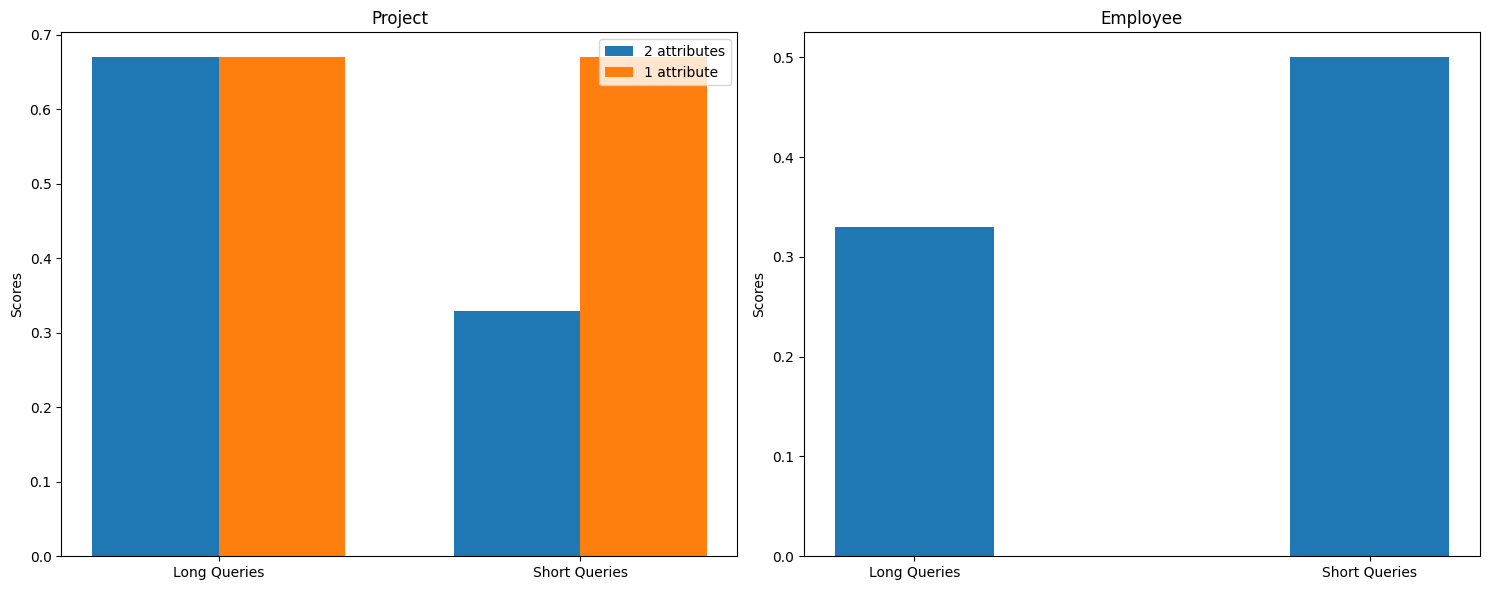

In [142]:
plot(robustness_for_long_queries, robustness_for_short_queries, second_dim=True)

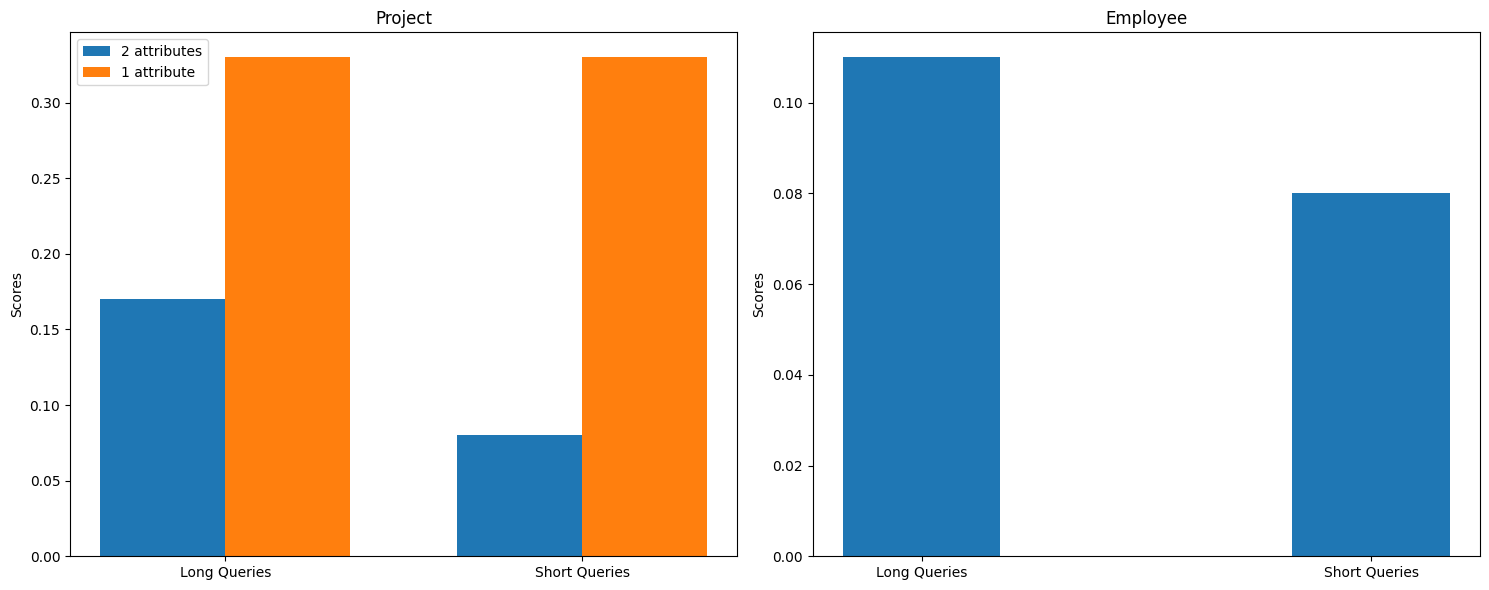

In [129]:
plot(accuracy_for_long_queries, accuracy_for_short_queries)

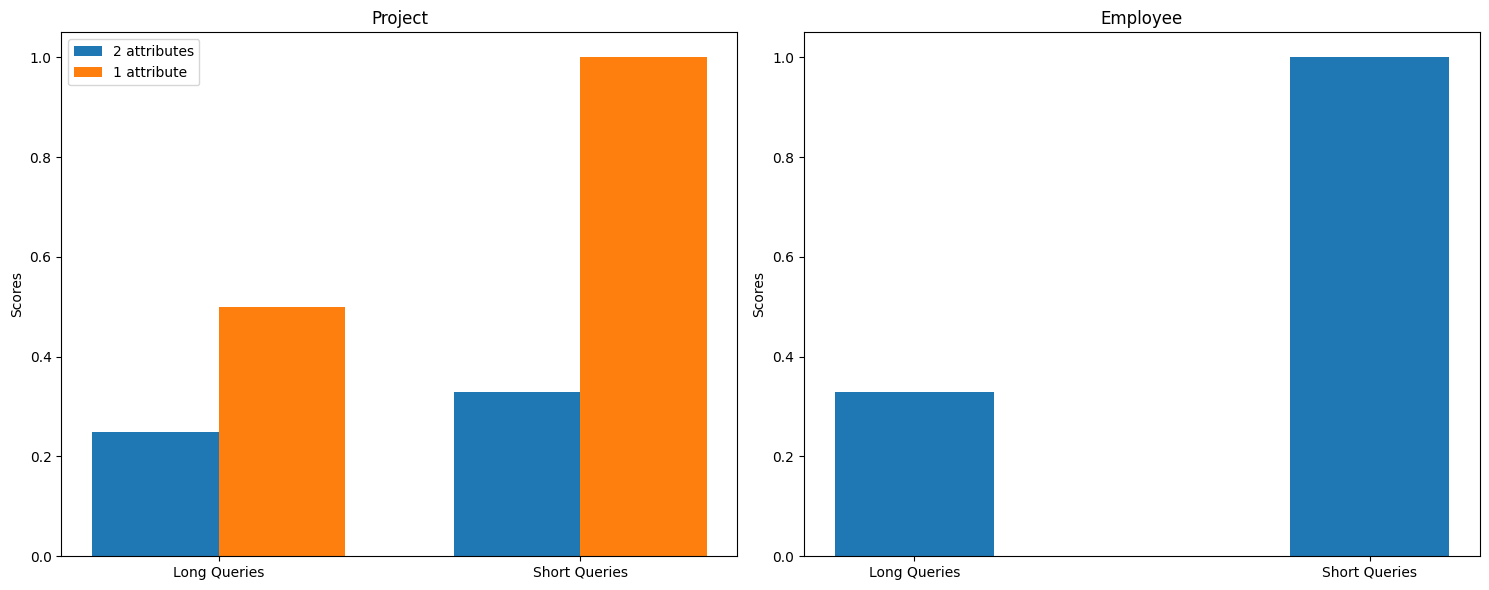

In [97]:
plot(best_case_accuracy_for_long_queries, best_case_accuracy_for_short_queries)

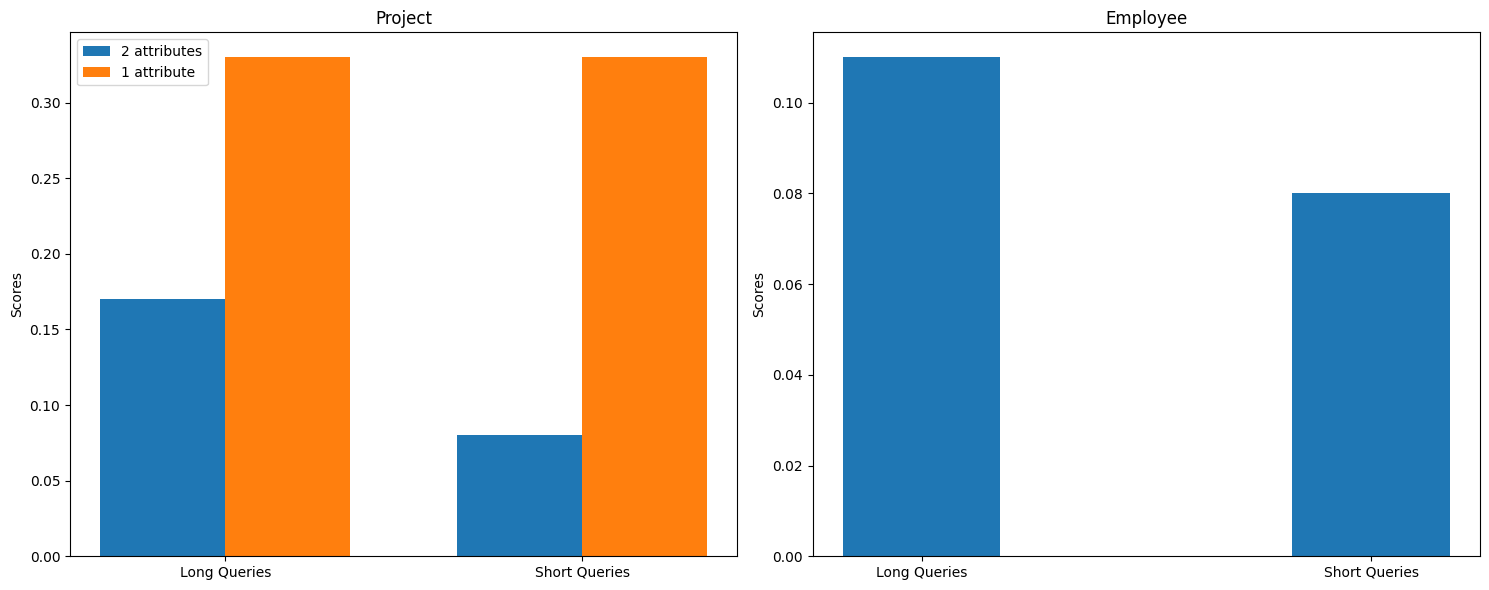

In [96]:
plot(accuracy_for_long_queries, accuracy_for_short_queries)

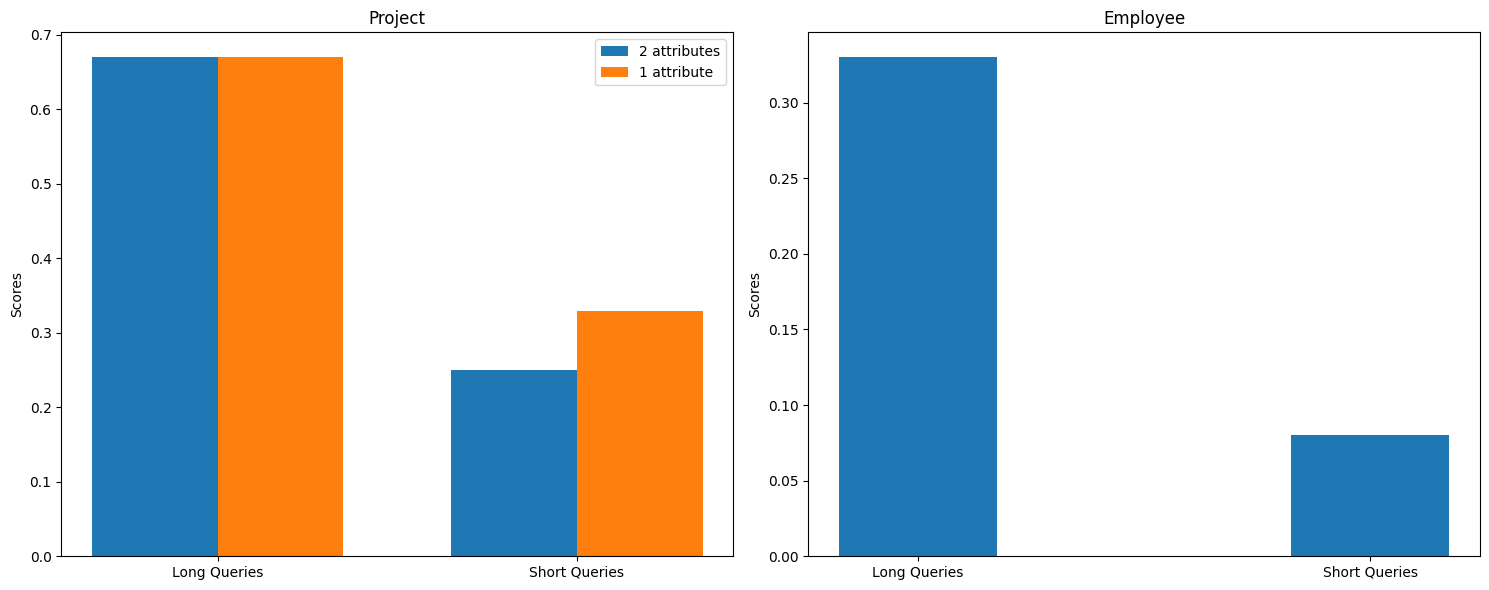

In [93]:
plot(robustness_for_long_queries, robustness_for_short_queries)

In [95]:
accuracy_for_short_queries.keys()

dict_keys(['Project_select1', 'Project_select2', 'Employee_select1', 'Company'])

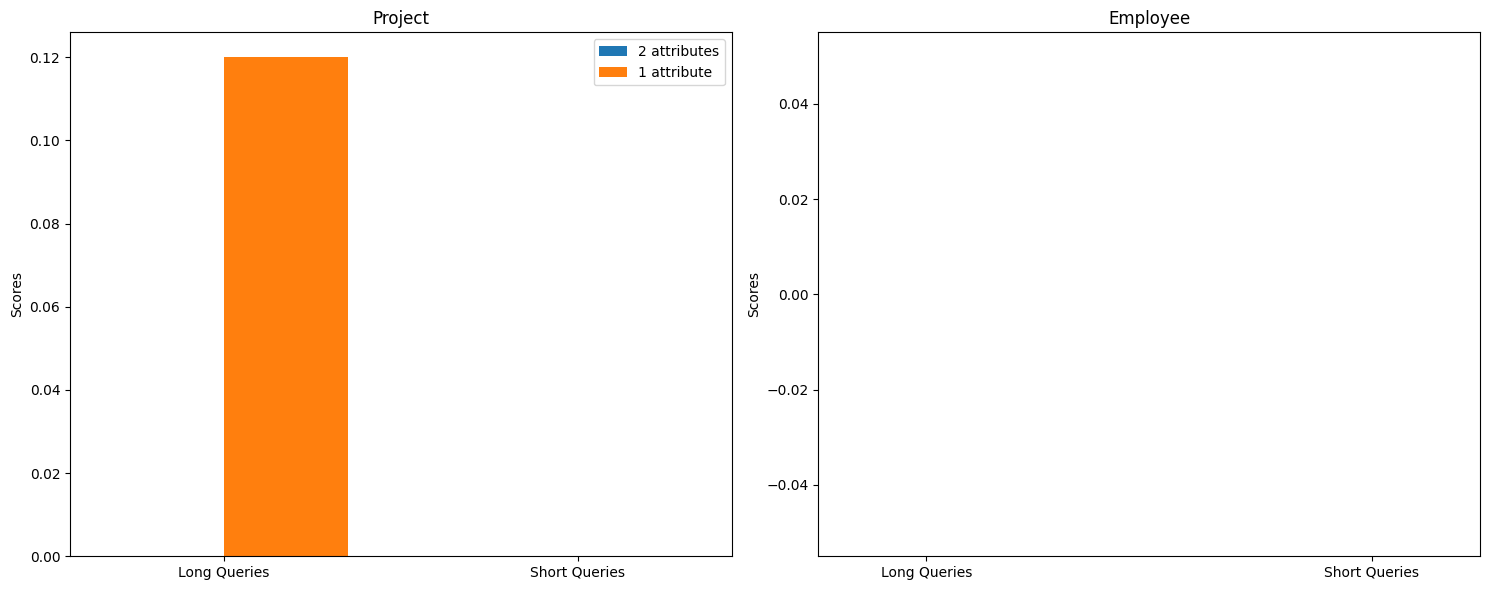

In [88]:
plot(robust_rates_for_long_queries, robust_rates_for_short_queries)

In [ ]:
# ~~~~~ Aurp Project ~~~~~
# ~~~~~ Non-robust (Long) ~~~~~
# Competent Group: 5 template logics * 3 long SQL-to-text transform rate * 8 documents = 120 long text queries 
# Gap groups:      5 template logics * 1 long SQL-to-text transform rate * 2  documents = 10 text queries
# Upper bound of Accuracy: 120/(120+10)= 0.92

# ~~~~~ Robust (Short) ~~~~~
# Competent Group: 5 template logics * 3 long SQL-to-text transform rate * 8 documents = 120 long text queries 
# Gap groups:      5 template logics * 3 long SQL-to-text transform rate * 2  documents = 30 text queries
# Upper bound of Accuracy: (120)/150= 0.8

In [10]:
##### Group Robustness (tag to correct/total numbers)#####
# Long queries
# 0.125
# Short queries
# 0.25

##### Robustness #####
# Long queries
# 0.6666666666666666
# Short queries
# 0.6666666666666666

##### Accuracy #####
# Long queries
# 0.3333333333333333
# Short queries
# 0.3333333333333333

    # Short queries
        # print("Slightly Robust Cluster (short queries)")
        # print("Index for Query Logic: (Correct, Total) in each group")
        # 0: (1, 3), 
        # 1: (1, 3), 
        # 2: (3, 3), 
        # 3: (3, 3), 
        # 4: (0, 3), => gap group
        # 5: (0, 3), => gap group
        # 6: (0, 3), => gap group
        # 7: (0, 3)  => gap group
        # total: (8, 24)
        # no gap group: (8, 12)
        # print("\tAccuracy:", 8/24)
        # print("\tRobustness:", 8/12)





~~~~~Stratified Groups~~~~~
Non-robust cluster (long queries): (12 examples in gap groups, 12 in non-gap groups)
(Correct, Total) in each group
	Accuracy: 0.3333333333333333
	Robustness: 0.6666666666666666


Robust Cluster (short queries): (12 examples in gap groups, 12 in non-gap groups)
(Correct, Total) in each group
	Accuracy: 0.4583333333333333
	Robustness: 0.9166666666666666


~~~~~Unbalanced Groups~~~~~
Non-robust: (6 examples in gap group, 12 in non-gap group)
(Correct, Total) in each group
Non-robust clusters (long queries)
	Accuracy: 0.4444444444444444
	Robustness: 0.6666666666666666


Robust Cluster (short queries)
Robust: (12 examples in gap group, 12 in non-gap group)
	Accuracy: 0.4583333333333333
	Robustness: 0.9166666666666666
